<a href="https://colab.research.google.com/github/anton-gavrilin/colab_google/blob/main/lstm_movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a recurrent artificial neural network (LSTM) to classify movie reviews as either positive or negative (sentiment analysis).

Import usable libraries for network

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Load data from tensorflow datasets.imdb and preprocess the data and limit each review to a maximum between 250 and 500 words

In [235]:
max_size = 1000
max_features = 20000
maxlen = 80
look_back = 1

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Resize data for be smaller
x_train, y_train = x_train[:max_size], y_train[:max_size]
x_test, y_test = x_test[:max_size], y_test[:max_size]

def filter_data(data, labels):
  filtered_data = []
  filtered_labels = []

  for i in range(len(data)):
      if 250 <= len(data[i]) <= 500:
          filtered_data.append([len(data[i])])
          filtered_labels.append(labels[i])
  return filtered_data, filtered_labels

# Filtering data reviews between 250 and 500 words
(x_train, y_train) = filter_data(x_train, y_train)
(x_test, y_test) = filter_data(x_test, y_test)

# Join together train and test for full dataset
dataset = x_train + x_test
dataset_labels = y_train + y_test

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

# Modify numpy.array's to be simple lists
x_train = np.array(x_train).tolist()
y_train = np.array(y_train).tolist()

x_test = np.array(x_test).tolist()
y_test = np.array(y_test).tolist()

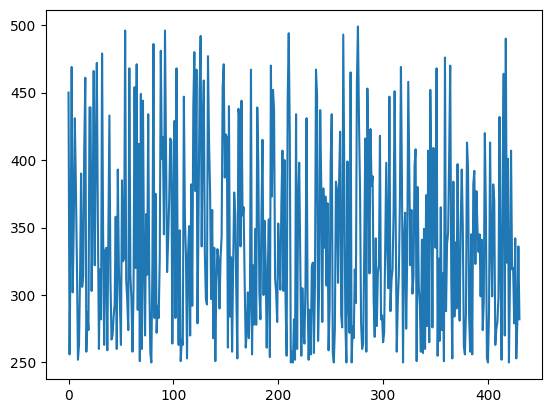

In [236]:
plt.plot(dataset)
plt.show()

Normalize the dataset to be between 0 and 1

In [237]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

The LSTM network has Embedding layer for numerical representation of a piece of information, a visible layer(Dense) with 1 input, a hidden layer with 128 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM memory blocks.

In [238]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Can be used different optimizers and configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm_15 (LSTM)              (None, 128)               131584    
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


The network is trained for 20 epochs, and a batch size of 32 is used.

In [239]:
batch_size = 32
epochs_size = 20
model.fit(x_train, y_train, validation_data=(x_test, y_test),
          batch_size=batch_size, epochs=epochs_size)

Epoch 1/20
7/7 [==============================] - 7s 401ms/step - loss: 0.6989 - accuracy: 0.5046 - val_loss: 0.6925 - val_accuracy: 0.5164
Epoch 2/20
7/7 [==============================] - 2s 329ms/step - loss: 0.6911 - accuracy: 0.5367 - val_loss: 0.6937 - val_accuracy: 0.4836
Epoch 3/20
7/7 [==============================] - 2s 324ms/step - loss: 0.6859 - accuracy: 0.6009 - val_loss: 0.6931 - val_accuracy: 0.5258
Epoch 4/20
7/7 [==============================] - 3s 534ms/step - loss: 0.6804 - accuracy: 0.6514 - val_loss: 0.6934 - val_accuracy: 0.5070
Epoch 5/20
7/7 [==============================] - 2s 332ms/step - loss: 0.6673 - accuracy: 0.8394 - val_loss: 0.6927 - val_accuracy: 0.5399
Epoch 6/20
7/7 [==============================] - 2s 318ms/step - loss: 0.6487 - accuracy: 0.8853 - val_loss: 0.6919 - val_accuracy: 0.4836
Epoch 7/20
7/7 [==============================] - 2s 324ms/step - loss: 0.6169 - accuracy: 0.8761 - val_loss: 0.6948 - val_accuracy: 0.4930
Epoch 8/20
7/7 [====

Calculate score and accuracy of test and train

In [240]:
testScore, testAcc = model.evaluate(x_test, y_test, batch_size=batch_size)
trainScore, trainAcc = model.evaluate(x_train, y_train, batch_size=batch_size)

print(f'Test config: score: {testScore}, accuracy: {testAcc}')
print(f'Train config: score: {trainScore}, accuracy: {trainAcc}')

7/7 [==============================] - 0s 38ms/step - loss: 0.2044 - accuracy: 0.8807
Test config: score: 1.5217010974884033, accuracy: 0.5070422291755676
Train config: score: 0.20443542301654816, accuracy: 0.8807339668273926


Transforming into the expected structure using created function and numpy.reshape().

In [241]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

# Transform lists to numpy.array's
x_train = np.array(x_train, dtype=np.float64)
x_test = np.array(x_test, dtype=np.float64)

trainX, trainY = create_dataset(x_train)
testX, testY = create_dataset(x_test)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Estimating the performance of the model on the train and test datasets

In [242]:
# make predictions
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(np.array(y_train).reshape(-1, 1))

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))

7/7 [==============================] - 0s 38ms/step


Time to visualize data, where the original dataset in blue, the training predictions in green, and the test predictions in red.

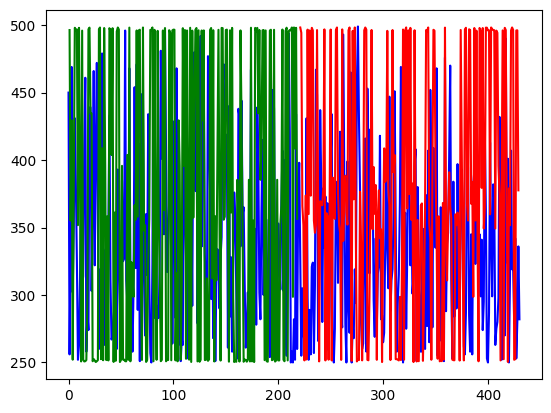

In [243]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredict = testPredict[:209, :].reshape((209, 1))
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Sorted data
# dataset = np.sort(dataset, axis=0)
# trainPredictPlot = np.sort(trainPredictPlot, axis=0)
# testPredictPlot = np.sort(testPredictPlot, axis=0)

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset),'b')
plt.plot(trainPredictPlot,'g')
plt.plot(testPredictPlot,'r')
plt.show()